<a href="https://colab.research.google.com/github/PranjalMinocha/CycleGAN/blob/main/T1_to_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt

In [3]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

In [4]:
# dataset path
path = '/content/drive/MyDrive/CycleGANs_ProtonAutoML/'

# load dataset A - T1 images
dataA_all = load_images(path + 'TrainT1/')
print('Loaded dataA: ', dataA_all.shape)

from sklearn.utils import resample
#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all, 
                 replace=True,     
                 n_samples=50,    
                 random_state=42) 

Loaded dataA:  (43, 256, 256, 3)


In [5]:
# load dataset B - T2 images
dataB_all = load_images(path + 'TrainT2/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration

#We could have just read the list of files and only load a subset, better memory management. 
dataB = resample(dataB_all, 
                 replace=True,     
                 n_samples=50,    
                 random_state=42) 

Loaded dataB:  (46, 256, 256, 3)


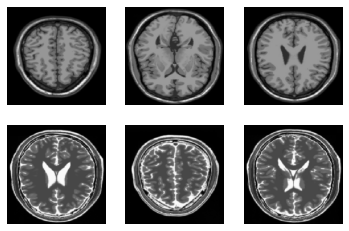

In [6]:
# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()

In [7]:
# load image data
data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)

Loaded (50, 256, 256, 3) (50, 256, 256, 3)


In [8]:
#Preprocess data to change input range to values between -1 and 1
# This is because the generator uses tanh activation in the output layer
#And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [9]:
dataset = preprocess_data(data)

In [10]:
%cd /content/drive/MyDrive/CycleGANs_ProtonAutoML/

/content/drive/MyDrive/CycleGANs_ProtonAutoML


In [11]:
from cycleGAN_model import define_generator, define_discriminator, define_composite_model, train
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from datetime import datetime 
start1 = datetime.now() 
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=50)

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

In [12]:
# Use the saved cyclegan models for image translation
from instancenormalization import InstanceNormalization  
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

In [13]:
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

In [14]:
# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

In [15]:
# load dataset
A_data = resample(dataA_all, 
                 replace=True,     
                 n_samples=50,    
                 random_state=42) # reproducible results

B_data = resample(dataB_all, 
                 replace=True,     
                 n_samples=50,    
                 random_state=42) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5

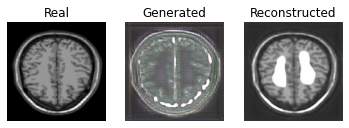

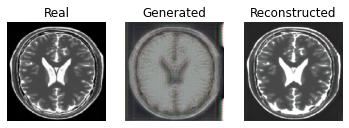

In [16]:
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_000250.h5', cust)
model_BtoA = load_model('g_model_BtoA_000250.h5', cust)

# plot A->B->A (Monet to photo to Monet)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B (Photo to Monet to Photo)
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)